# Compare samplers

In this notebook, we'll compare the different samplers implemented in `tupak`. As of this version, we don't compare the outputs, only how to run them and the timings for their default setup.

## Setup

In [1]:
import numpy as np
import pylab as plt

%load_ext autoreload
%autoreload 2

import tupak

tupak.utils.setup_logger()

time_duration = 1.
sampling_frequency = 4096.

injection_parameters = dict(mass_1=36., mass_2=29., a_1=0, a_2=0, tilt_1=0, tilt_2=0, phi_12=0, phi_jl=0,
                            luminosity_distance=100., iota=0.4, phase=1.3, waveform_approximant='IMRPhenomPv2',
                            reference_frequency=50., ra=1.375, dec=-1.2108, geocent_time=1126259642.413,
                            psi=2.659)

waveform_generator = tupak.waveform_generator.WaveformGenerator(
    sampling_frequency=sampling_frequency,
    time_duration=time_duration,
    frequency_domain_source_model=tupak.source.lal_binary_black_hole,
    parameters=injection_parameters)

hf_signal = waveform_generator.frequency_domain_strain()

H1 = tupak.detector.get_empty_interferometer('H1')
H1.set_data(sampling_frequency=sampling_frequency, duration=time_duration,
            from_power_spectral_density=True)
H1.inject_signal(waveform_polarizations=hf_signal, parameters=injection_parameters)

IFOs = [H1]

likelihood = tupak.likelihood.Likelihood(IFOs, waveform_generator)

17:13 INFO    : Setting H1 data using noise realization from providedpower_spectal_density
17:13 INFO    : Injection found with optimal SNR = 223.94 and matched filter SNR = 224.33 in H1


## Prior

For this test, we will simply search of the sky position, setting the other parameters to their simulated values.

In [2]:
priors = tupak.prior.parse_floats_to_fixed_priors(injection_parameters)
priors['ra'] = tupak.prior.Uniform(0, 2*np.pi, 'ra')
priors['dec'] = tupak.prior.Uniform(-np.pi/2, np.pi/2, 'dec')

17:13 INFO    : Expected parameter waveform_approximant to be a float or int but was <type 'str'> instead. Will not be converted.


## PyMultinest

17:13 WARNING : waveform_approximant cannot be converted to delta function prior.
17:13 WARNING : If required the default prior will be used.
17:13 INFO    : Writing priors to outdir/prior.txt
17:13 INFO    : Search parameters:
17:13 INFO    :   ra ~ Uniform(support=6.28318530718, minimum=0, name=ra, maximum=6.28318530718, _Prior__latex_label=$\mathrm{RA}$)
17:13 INFO    :   dec ~ Uniform(support=3.14159265359, minimum=-1.57079632679, name=dec, maximum=1.57079632679, _Prior__latex_label=$\mathrm{DEC}$)
17:13 INFO    :   psi = 2.659
17:13 INFO    :   a_2 = 0
17:13 INFO    :   a_1 = 0
17:13 INFO    :   geocent_time = 1126259642.41
17:13 INFO    :   reference_frequency = 50.0
17:13 INFO    :   phi_jl = 0
17:13 INFO    :   phase = 1.3
17:13 INFO    :   mass_2 = 29.0
17:13 INFO    :   mass_1 = 36.0
17:13 INFO    :   phi_12 = 0
17:13 INFO    :   luminosity_distance = 100.0
17:13 INFO    :   tilt_2 = 0
17:13 INFO    :   iota = 0.4
17:13 INFO    :   tilt_1 = 0
17:13 INFO    : Using sampler Pym

  analysing data from outdir/pymultinest_pymultinest/.txt


17:14 WARNING : Parameter $\mathrm{DEC}$ in chain pymultinest is not constrained


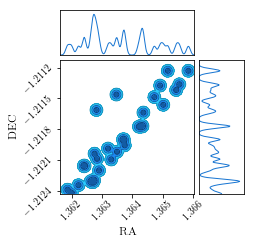

nsamples: 35
noise_logz: -27238.584
logz: -2015.254 +/-  0.283
log_bayes_factor: 25223.330 +/-  0.283

CPU times: user 12.7 s, sys: 1.08 s, total: 13.8 s
Wall time: 14.2 s


In [3]:
%%time 
result = tupak.sampler.run_sampler(
    likelihood, priors=priors, sampler='pymultinest', label='pymultinest',
    npoints=200, verbose=False, resume=False)
fig = result.plot_corner(save=False)
plt.show()
print(result)

# dynesty

17:14 INFO    : Supplied PDF is not normalised, normalising.
17:14 WARNING : No default prior found for unspecified variable waveform_approximant.
17:14 WARNING : This variable will NOT be sampled.
17:14 INFO    : Writing priors to outdir/prior.txt
17:14 INFO    : Search parameters:
17:14 INFO    :   ra ~ Uniform(support=6.28318530718, minimum=0, name=ra, maximum=6.28318530718, _Prior__latex_label=$\mathrm{RA}$)
17:14 INFO    :   dec ~ Uniform(support=3.14159265359, minimum=-1.57079632679, name=dec, maximum=1.57079632679, _Prior__latex_label=$\mathrm{DEC}$)
17:14 INFO    :   psi = 2.659
17:14 INFO    :   a_2 = 0
17:14 INFO    :   a_1 = 0
17:14 INFO    :   geocent_time = 1126259642.41
17:14 INFO    :   reference_frequency = 50.0
17:14 INFO    :   phi_jl = 0
17:14 INFO    :   phase = 1.3
17:14 INFO    :   mass_2 = 29.0
17:14 INFO    :   mass_1 = 36.0
17:14 INFO    :   phi_12 = 0
17:14 INFO    :   luminosity_distance = 100.0
17:14 INFO    :   tilt_2 = 0
17:14 INFO    :   iota = 0.4
17:14 

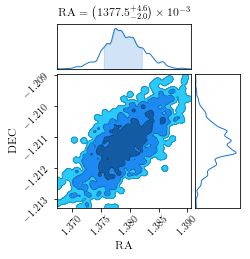

nsamples: 3501
noise_logz: -27238.584
logz: -1998.714 +/-  0.256
log_bayes_factor: 25239.870 +/-  0.256

CPU times: user 55.2 s, sys: 9.01 s, total: 1min 4s
Wall time: 53.2 s


In [4]:
%%time 
result = tupak.sampler.run_sampler(
    likelihood, priors=priors, sampler='dynesty', label='dynesty',
    bound='multi', sample='rwalk', npoints=200, walks=1, verbose=False,
    update_interval=100)
fig = result.plot_corner(save=False)
plt.show()
print(result)

# Dynamic Nested Sampling (Dynesty)

See [the dynesty docs](http://dynesty.readthedocs.io/en/latest/dynamic.html#). Essentially, this methods improves the posterior estimation over that of standard nested sampling.

17:15 INFO    : Supplied PDF is not normalised, normalising.
17:15 WARNING : No default prior found for unspecified variable waveform_approximant.
17:15 WARNING : This variable will NOT be sampled.
17:15 INFO    : Writing priors to outdir/prior.txt
17:15 INFO    : Search parameters:
17:15 INFO    :   ra ~ Uniform(support=6.28318530718, minimum=0, name=ra, maximum=6.28318530718, _Prior__latex_label=$\mathrm{RA}$)
17:15 INFO    :   dec ~ Uniform(support=3.14159265359, minimum=-1.57079632679, name=dec, maximum=1.57079632679, _Prior__latex_label=$\mathrm{DEC}$)
17:15 INFO    :   psi = 2.659
17:15 INFO    :   a_2 = 0
17:15 INFO    :   a_1 = 0
17:15 INFO    :   geocent_time = 1126259642.41
17:15 INFO    :   reference_frequency = 50.0
17:15 INFO    :   phi_jl = 0
17:15 INFO    :   phase = 1.3
17:15 INFO    :   mass_2 = 29.0
17:15 INFO    :   mass_1 = 36.0
17:15 INFO    :   phi_12 = 0
17:15 INFO    :   luminosity_distance = 100.0
17:15 INFO    :   tilt_2 = 0
17:15 INFO    :   iota = 0.4
17:15 

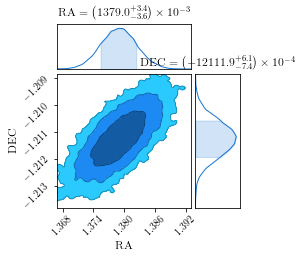

nsamples: 18812
noise_logz: -27238.584
logz: -1998.752 +/-  0.209
log_bayes_factor: 25239.832 +/-  0.209

CPU times: user 10min 49s, sys: 44.9 s, total: 11min 34s
Wall time: 10min 35s


In [5]:
%%time 
result = tupak.sampler.run_sampler(
    likelihood, priors=priors, sampler='dynesty', label='dynesty_dynamic',
    bound='multi', nlive=250, sample='unif', verbose=True,
    update_interval=100, dynamic=True)
fig = result.plot_corner(save=False)
plt.show()
print(result)

# ptemcee

17:25 INFO    : Supplied PDF is not normalised, normalising.
17:25 WARNING : No default prior found for unspecified variable waveform_approximant.
17:25 WARNING : This variable will NOT be sampled.
17:25 INFO    : Writing priors to outdir/prior.txt
17:25 INFO    : Search parameters:
17:25 INFO    :   ra ~ Uniform(support=6.28318530718, minimum=0, name=ra, maximum=6.28318530718, _Prior__latex_label=$\mathrm{RA}$)
17:25 INFO    :   dec ~ Uniform(support=3.14159265359, minimum=-1.57079632679, name=dec, maximum=1.57079632679, _Prior__latex_label=$\mathrm{DEC}$)
17:25 INFO    :   psi = 2.659
17:25 INFO    :   a_2 = 0
17:25 INFO    :   a_1 = 0
17:25 INFO    :   geocent_time = 1126259642.41
17:25 INFO    :   reference_frequency = 50.0
17:25 INFO    :   phi_jl = 0
17:25 INFO    :   phase = 1.3
17:25 INFO    :   mass_2 = 29.0
17:25 INFO    :   mass_1 = 36.0
17:25 INFO    :   phi_12 = 0
17:25 INFO    :   luminosity_distance = 100.0
17:25 INFO    :   tilt_2 = 0
17:25 INFO    :   iota = 0.4
17:25 

A Jupyter Widget

/home/user1/anaconda2/lib/python2.7/site-packages/tupak/sampler.py:152: RuntimeWarning: divide by zero encountered in log
  zip(self.__search_parameter_keys, theta)])
17:27 INFO    : Saving walkers plot to filename


17:27 INFO    : Max autocorr time = 45.9041728596
17:27 INFO    : Tswap frac = [0.0176 0.0176]
17:27 INFO    : Renaming existing file outdir/ptemcee_result.h5 to outdir/ptemcee_result.h5.old
17:27 INFO    : Saving result to outdir/ptemcee_result.h5
17:27 WARNING : Parameter $\mathrm{RA}$ in chain ptemcee is not constrained


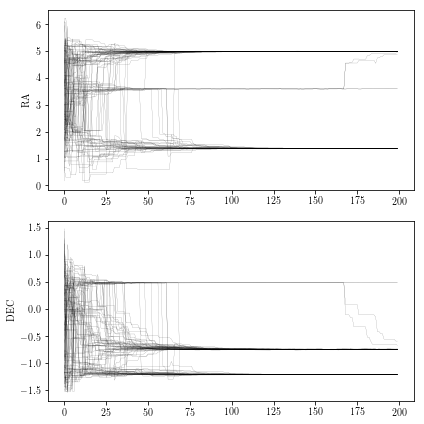

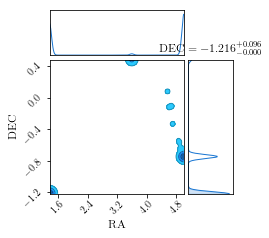

nsamples: 10000
noise_logz: -27238.584
logz:    nan +/-    nan
log_bayes_factor:    nan +/-    nan

CPU times: user 1min 39s, sys: 1.02 s, total: 1min 40s
Wall time: 1min 39s


In [6]:
%%time 
result = tupak.sampler.run_sampler(
    likelihood, priors=priors, sampler='ptemcee', label='ptemcee',
    nwalkers=100, nsteps=200, nburn=100, ntemps=2,
    tqdm='tqdm_notebook')
fig = result.plot_corner(save=False)
plt.show()
print(result)